# Library and Setup

In [5]:
import pandas as pd # Data management tools
import numpy as np # Mathematical operations
import psycopg2 # Access to SQL
import re # Regex and other lookup tools
import datetime

In [6]:
conn = psycopg2.connect(
    database="testing",
    user="postgres",
    password="forest25",
    host="localhost",
    port="5432"
)

In [7]:
def fetch_table_to_df(conn, query):
    """"Extracts entire table(s) from an SQL database. 
    
    conn: Should be a connect function from psycopg2.
    query: Tables to be extracted from the database.

    """
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    column_names = [desc[0] for desc in cur.description]
    df = pd.DataFrame(rows, columns=column_names).replace({np.nan}, None)
    cur.close()
    return df

In [8]:
tables = "tree_monitorings", "measurement_informations", "biomass_formulas", "tree_biomasses", 'taxonomies', 'tree_samplings', 'plot_informations', "site_informations"
for table in tables:
    table_name = f"{table}"
    globals()[table_name] = fetch_table_to_df(conn, f"SELECT * FROM {table}")

# Biomass Calculation

# Preparation

Python supports $pow()$, only need to remove $ sign from the equation

In [9]:
#replacements = {'pow' : '', ',' : '**'}
#biomass_formulas['formula_python'] = biomass_formulas['formula'].replace(replacements, regex = True).str.replace('$','')

biomass_formulas['formula_python'] = biomass_formulas['formula'].str.replace('$','') #Simpler, pow() exists in python as well

C:\Users\zrmuc\AppData\Local\Temp\ipykernel_12428\4081924158.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  biomass_formulas['formula_python'] = biomass_formulas['formula'].str.replace('$','') #Simpler, pow() exists in python as well


Changing data types for smooth operations

In [10]:
tree_monitorings[['tree_height', 'tree_dbh']] = tree_monitorings[['tree_height', 'tree_dbh']].astype('float')
taxonomies['id'] = taxonomies['id'].astype('int')
taxonomies['wood_density'] = taxonomies['wood_density'].astype('float')
tree_monitorings['taxonomy_id'] = tree_monitorings['taxonomy_id'].astype('int')

Current data shows combination of hasHeight+noDBH, noHeight+noDBH, hasHeight+hasDBH but no noHeight+hasDBH

In [11]:
tree_monitorings[['tree_height','tree_dbh']].notna().value_counts()

tree_height  tree_dbh
True         False       6301
False        False       4193
True         True        3234
dtype: int64

Standardizing tree_species names (unfinished, need to deal with NAs)

In [12]:
tree_species = ['Suren', 'Kopi Liberika', 'Citrus', 'Casuarina','Other', 'Meranti','Soursop','Gaharu','Mango','Rosewood','Orange','Tengkurung','Durian','Cajuput','Jackfruit','Rambutan','Clove','Coffee', 'Lamtoro','Meranti Bakau', 'Meranti Bunga', 'Asam Gelugur','Avocado','Cempedak', 'Asam', 'Tampui', 'Sirsak', 'Kuras','Bitterbean','Mentangor']

In [13]:
#x = [next(iter(x), np.nan) 
#          for x in map(lambda x: difflib.get_close_matches(x, tree_species, cutoff = 0.7), tree_monitorings['tree_species']) if x]

## Full Census Biomass Calculation

Adding column of biomass_formula_id for simpler referencing in upcoming operations

In [14]:
dbh_exist = tree_monitorings['tree_dbh'].notna() # check which is not NA
height_exist = tree_monitorings['tree_height'].notna() # check which is not NA

trees_wood_density = [taxonomies.loc[taxonomies['id'] == tax_id, 'wood_density'].values[0] 
                if tax_id in taxonomies['id'].values else None
                for tax_id in tree_monitorings['taxonomy_id']]

In [15]:
for index, (dbh, height, wood) in enumerate(zip(dbh_exist, height_exist, trees_wood_density)):
    if dbh == 1 and height == 1:
        if (wood != wood or wood == None):
            tree_monitorings.loc[index, 'biomass_formulas_id'] = 7
        else:
            tree_monitorings.loc[index, 'biomass_formulas_id'] = 3
    elif (dbh == 1 and height == 0):
        tree_monitorings.loc[index, 'biomass_formulas_id'] = 5
    elif (dbh == 0 and height == 1):
        tree_monitorings.loc[index, 'biomass_formulas_id'] = 4
    else:
        tree_monitorings.loc[index, 'biomass_formulas_id'] = None

Filtering data from measurement_information which also exist in tree_monitorings

In [16]:
type1_measurement = measurement_informations[(measurement_informations['monitoring_id'].isin(tree_monitorings['id'])== True) & measurement_informations['monitoring_type'] == 1]

In [17]:
tree_monitorings['tree_cond'].value_counts(dropna = False)

0       8011
1       3084
None    2156
2        477
Name: tree_cond, dtype: int64

In [18]:
#measurement = measurement_informations[(measurement_informations['monitoring_id'].isin(tree_monitorings['id'])== True)]

In [19]:
taxonomy_dict = taxonomies.set_index('id')['wood_density'].to_dict() #Set wood identity for referral from taxonomy_id

biomass_index = [] #empty list for storing valid biomass ids
result = [] #empty list for storing results
for index_used in type1_measurement['monitoring_id']:
    tree_dbh     = tree_monitorings.loc[tree_monitorings['id'] == index_used,'tree_dbh'].values[0]
    tree_height  = tree_monitorings.loc[tree_monitorings['id'] == index_used,'tree_height'].values[0]
    biomass_id   = tree_monitorings.loc[tree_monitorings['id'] == index_used,'biomass_formulas_id'].values[0]
    tax_id       = tree_monitorings.loc[tree_monitorings['id'] == index_used,'taxonomy_id'].values[0]
    wood_density = taxonomy_dict.get(tax_id)
    if (biomass_id != biomass_id or biomass_id == None):
        continue
    else:
        biomass_form = biomass_formulas.loc[biomass_formulas['id'] == biomass_id, 'formula_python']
        for biomass in biomass_form:
            biomass_result = eval(biomass)
            result.append(biomass_result)
            biomass_index.append(index_used)
#            print("dbh:", tree_dbh,
#                  "height:", tree_height,
##                  "index:", index_used, 
 #                 "formula", biomass_form,
 #                 "result:", biomass_result)

### Creating Biomass Table/Dataframe

In [20]:
tree_biomasses_python = type1_measurement[type1_measurement['monitoring_id'].isin(biomass_index) == True]

In [21]:
tree_biomasses_python = tree_biomasses_python.drop(['id','timenow','start', 'end','username','notes','_xform_id','_xform_id_string','monitoring_order','month_monitoring','phase'], axis = 1)


In [22]:
tree_biomasses_python['result'] = result

In [23]:
tree_biomasses_python['taxonomy_id'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'taxonomy_id'].values[0] 
                if mon_id in tree_monitorings['id'].values else None
                for mon_id in tree_biomasses_python['monitoring_id']]

In [24]:
tree_biomasses_python['tree_species'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'tree_species'].values[0] 
                if mon_id in tree_monitorings['id'].values else None
                for mon_id in tree_biomasses_python['monitoring_id']]

In [25]:
tree_biomasses_python['tree_id'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'tree_id'].values[0] 
                if mon_id in tree_monitorings['id'].values else None
                for mon_id in tree_biomasses_python['monitoring_id']]

In [26]:
tree_biomasses_python['submission_time'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'submission_time'].values[0] 
                if mon_id in tree_monitorings['id'].values else None
                for mon_id in tree_biomasses_python['monitoring_id']]

In [27]:
tree_biomasses_python['updated_at'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


In [28]:
carbon = []
for res in result:
    if (res != res or res == None):
        continue
    else:
        carbon.append(res * 0.5 * 3.67) # biomass * 0.5 * 3.67
tree_biomasses_python['carbon'] = carbon

In [29]:
tree_biomasses_python['id'] = range(1,len(tree_biomasses_python)+1)

In [30]:
tree_biomasses_python = tree_biomasses_python[['id','monitoring_id','tree_id','tree_species','taxonomy_id','result','carbon','date_monitoring','submission_time','created_at','updated_at']]
tree_biomasses_python

,id,monitoring_id,tree_id,tree_species,taxonomy_id,result,carbon,date_monitoring,submission_time,created_at,updated_at
1653,1,62,AA01T0180,Meranti,5,0.000000,0.000000,2018-04-23,2019-03-29 14:36:00,2021-08-01 20:19:02,2025-03-03 09:24:51
1686,2,1,AA01T0001,Gaharu,4,0.030735,0.056398,2018-02-21,2019-03-29 14:02:38,2021-08-01 20:19:01,2025-03-03 09:24:51
1793,3,30838,BB-01-0-0024,Suren,64,0.295311,0.541896,2024-08-15,2024-09-11 00:00:00,2024-09-11 18:13:55,2025-03-03 09:24:51
1794,4,30839,BB-01-0-0026,Suren,64,0.144379,0.264936,2024-08-15,2024-09-11 00:00:00,2024-09-11 18:13:55,2025-03-03 09:24:51
1795,5,30840,BB-01-0-0027,Suren,64,0.329164,0.604016,2024-08-15,2024-09-11 00:00:00,2024-09-11 18:13:55,2025-03-03 09:24:51
...,...,...,...,...,...,...,...,...,...,...,...
18791,10581,36980,CL-10-0-1843,suren,64,0.473252,0.868417,2023-08-21,2024-09-11 00:00:00,2024-09-11 21:22:56,2025-03-03 09:24:51
18792,10582,36981,CL-10-0-1844,suren,64,0.577320,1.059382,2023-08-21,2024-09-11 00:00:00,2024-09-11 21:22:56,2025-03-03 09:24:51
18793,10583,36982,CL-10-0-1845,suren,64,0.943740,1.731763,2023-08-21,2024-09-11 00:00:00,2024-09-11 21:22:56,2025-03-03 09:24:51
18794,10584,36983,CL-10-0-1846,suren,64,0.224837,0.412575,2023-08-21,2024-09-11 00:00:00,2024-09-11 21:22:56,2025-03-03 09:24:51


### Compare result to original table

In [31]:
#tree_biomasses_python['tree_cond'] = [tree_monitorings.loc[tree_monitorings['id'] == mon_id, 'tree_cond'].values[0] 
#                if mon_id in tree_monitorings['id'].values else None
#                for mon_id in tree_biomasses_python['monitoring_id']]

In [32]:
tree_biomasses_python.merge(tree_biomasses, on = ['monitoring_id'], how = 'inner')[['result_x','result_y']]

,result_x,result_y
0,0.000000,None
1,0.000000,None
2,0.030735,0.03073
3,0.030735,0.03073
4,0.295311,None
...,...,...
10580,0.473252,None
10581,0.577320,None
10582,0.943740,None
10583,0.224837,None


## Sampling Biomass Calculation

In [33]:
sampling_dbh_exist = tree_samplings['tree_dbh'].notna() # check which is not NA
sampling_height_exist = tree_samplings['tree_height'].notna() # check which is not NA

sampling_trees_wood_density = [taxonomies.loc[taxonomies['id'] == tax_id, 'wood_density'].values[0] 
                if tax_id in taxonomies['id'].values else None
                for tax_id in tree_samplings['taxonomy_id']]

In [34]:
for index, (dbh, height, wood) in enumerate(zip(sampling_dbh_exist, sampling_height_exist, sampling_trees_wood_density)):
    if dbh == 1 and height == 1:
        if (wood != wood or wood == None):
            tree_samplings.loc[index, 'biomass_formulas_id'] = 7
        else:
            tree_samplings.loc[index, 'biomass_formulas_id'] = 3
    elif (dbh == 1 and height == 0):
        tree_samplings.loc[index, 'biomass_formulas_id'] = 5
    elif (dbh == 0 and height == 1):
        tree_samplings.loc[index, 'biomass_formulas_id'] = 4
    else:
        tree_samplings.loc[index, 'biomass_formulas_id'] = None

In [35]:
tree_samplings.biomass_formulas_id.value_counts(dropna= False)

4.0    11467
NaN     2378
7.0        2
Name: biomass_formulas_id, dtype: int64

In [36]:
tree_samplings[['tree_height','tree_dbh']] = tree_samplings[['tree_height','tree_dbh']].fillna('0')

In [37]:
taxonomy_dict = taxonomies.set_index('id')['wood_density'].to_dict() #Set wood identity for referral from taxonomy_id

sampling_results = [] #empty list for storing results
for index, row in tree_samplings.iterrows():
    tree_dbh     = float(row['tree_dbh'])
    tree_height  = float(row['tree_height'])
    biomass_id   = row['biomass_formulas_id']
    tax_id       = row['taxonomy_id']
    wood_density = taxonomy_dict.get(tax_id)
    if (biomass_id != biomass_id or biomass_id == None):
        sampling_results.append(None)
    else:
        biomass_form = biomass_formulas.loc[biomass_formulas['id'] == biomass_id, 'formula_python']
        for biomass in biomass_form:
            biomass_result = eval(biomass)
            sampling_results.append(biomass_result)

### Creating Sampling Biomass Table/Dataframe

In [38]:
tree_samplings['month_monitoring'] = pd.to_datetime(tree_samplings['date_monitoring'], format="%Y-%M-%d").dt.strftime("%b-%y")

In [39]:
sample_tree_biomasses_python = tree_samplings[['plot_information_id', 'subplot_id', 'tree_species', 'taxonomy_id', 'month_monitoring',
       'created_at', 'updated_at', 'tree_id', 'tree_height', 'tree_cond']]

In [40]:
sample_tree_biomasses_python['result'] = sampling_results

C:\Users\zrmuc\AppData\Local\Temp\ipykernel_12428\777817446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tree_biomasses_python['result'] = sampling_results


In [41]:
tree_biomasses_python['updated_at'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


In [42]:
carbon = []
for res in sampling_results:
    if (res != res or res == None):
        carbon.append(None)
    else:
        carbon.append(res * 0.5 * 3.67) # biomass * 0.5 * 3.67
sample_tree_biomasses_python['carbon'] = carbon

C:\Users\zrmuc\AppData\Local\Temp\ipykernel_12428\1091282493.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tree_biomasses_python['carbon'] = carbon


In [43]:
sample_tree_biomasses_python['id'] = range(1,len(sample_tree_biomasses_python)+1)

C:\Users\zrmuc\AppData\Local\Temp\ipykernel_12428\1565942968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_tree_biomasses_python['id'] = range(1,len(sample_tree_biomasses_python)+1)


In [44]:
sample_tree_biomasses_python = sample_tree_biomasses_python[['id', 'tree_id', 'plot_information_id', 'subplot_id', 'tree_species','taxonomy_id', 'tree_height', 'result', 'carbon','month_monitoring','created_at','updated_at']]

In [45]:
sample_tree_biomasses_python['tree_height'] = sample_tree_biomasses_python['tree_height'].astype(float)

BG

In [46]:
sample_tree_biomasses_python['centi_height'] = sample_tree_biomasses_python['tree_height'] * 100

In [47]:
sample_tree_biomasses_python['total_biomass'] = [pow(x, 3.0696) * 0.001 for x in sample_tree_biomasses_python['tree_height']]

In [48]:
sample_tree_biomasses_python['AGB'] = [pow(x, 2.8996) * 0.001 for x in sample_tree_biomasses_python['tree_height']]

In [49]:
sample_tree_biomasses_python[sample_tree_biomasses_python['tree_species'] == 'BG'][['total_biomass', 'AGB']].head(15).reset_index(drop = True).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
total_biomass,0.0,0.000017,0.000033,0.000080,0.000026,0.000026,0.000027,0.000011,0.000004,0.000006,0.000002,0.000008,0.000020,0.000047,0.000020
AGB,0.0,0.000021,0.000040,0.000092,0.000032,0.000032,0.000034,0.000014,0.000005,0.000008,0.000003,0.000011,0.000025,0.000056,0.000025


In [50]:
sample_tree_biomasses_python['old_result'] = sample_tree_biomasses_python['result']

In [51]:
sample_tree_biomasses_python['old_result']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
13842    0.003124
13843    0.006991
13844    0.011738
13845    0.005848
13846    0.007401
Name: old_result, Length: 13847, dtype: float64

<Axes: ylabel='Frequency'>

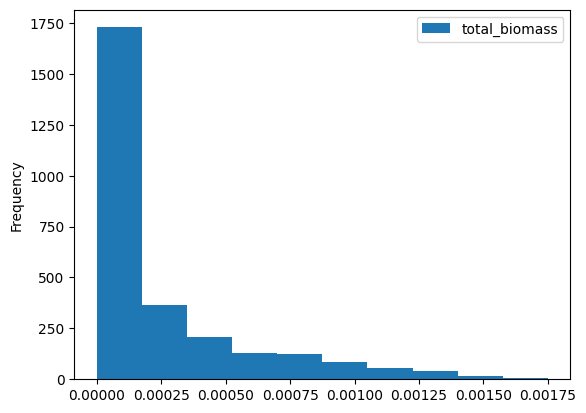

In [52]:
sample_tree_biomasses_python[sample_tree_biomasses_python['tree_species'] == 'BG'][['total_biomass']].reset_index(drop = True).plot.hist()

In [53]:
sample_tree_biomasses_python[sample_tree_biomasses_python['tree_species'] == 'BG'][['AGB', 'old_result']].mean()

AGB           0.000248
old_result    0.020026
dtype: float64

# Sampling_avgs

In [54]:
tree_samplings[['tree_height', 'tree_dbh']] = tree_samplings[['tree_height', 'tree_dbh']].astype(float)

In [55]:
proto_sampling_avgs = tree_samplings.groupby(['plot_information_id','taxonomy_id','month_monitoring'])[['tree_height','tree_dbh']].agg('mean').reset_index()

In [56]:
proto_sampling_avgs

,plot_information_id,taxonomy_id,month_monitoring,tree_height,tree_dbh
0,35,23,Jan-23,0.499250,0.000000
1,35,23,Jan-24,0.668633,0.000000
2,35,24,Jan-23,0.252427,0.000000
3,35,24,Jan-24,0.145215,0.000000
4,35,27,Jan-23,0.507168,0.000000
5,35,27,Jan-24,0.559611,0.000000
6,35,30,Jan-23,0.335667,0.000000
7,35,30,Jan-24,0.976889,0.000000
8,36,27,Jan-23,0.201691,0.000000
9,36,27,Jan-24,0.004013,0.000000


In [57]:
sampling_avgs = fetch_table_to_df(conn, "SELECT * FROM sampling_avgs")

In [58]:
yes = sampling_avgs.merge(proto_sampling_avgs)

In [59]:
yes

,id,plot_information_id,tree_species,taxonomy_id,avg_h,avg_dbh,month_monitoring,created_at,updated_at,site_id,phase,tree_height,tree_dbh
0,46,35,SC,30,0.296,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.976889,0.000000
1,48,35,SC,30,0.617,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.976889,0.000000
2,47,35,SC,23,0.376,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.668633,0.000000
3,68,35,RA,23,0.481,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.668633,0.000000
4,69,35,RA,23,0.518,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.668633,0.000000
5,70,35,RA,23,0.823,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.668633,0.000000
6,49,35,SA,27,0.358,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.559611,0.000000
7,50,35,SA,27,0.767,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.559611,0.000000
8,51,35,SA,27,0.862,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.559611,0.000000
9,52,37,RM,26,0.645,None,Jan-24,2024-03-04 09:22:30,2024-03-04 09:22:30,None,1,0.625693,0.000000


In [83]:
yes[['taxonomy_id', 'avg_h','tree_height']].value_counts()

taxonomy_id  avg_h  tree_height
0            0.608  0.000000       1
27           0.767  0.559611       1
26           0.662  0.625693       1
             0.728  0.625693       1
             0.794  0.814153       1
27           0.153  0.004013       1
             0.202  0.004013       1
             0.255  0.004013       1
             0.358  0.559611       1
             0.862  0.559611       1
25           0.930  0.630345       1
28           0.577  0.011818       1
             0.594  0.011818       1
             0.780  0.011818       1
29           0.300  0.000000       1
             0.330  0.000000       1
30           0.140  0.000000       1
             0.296  0.976889       1
26           0.645  0.625693       1
25           0.910  0.821967       1
0            0.678  0.000000       1
23           0.823  0.668633       1
             0.246  0.348321       1
             0.376  0.668633       1
             0.399  0.400517       1
             0.403  0.400517       1
      

# Data Analytics

In [61]:
data_analytics = fetch_table_to_df(conn, "SELECT * FROM data_analytics")

In [63]:
data_analytics.key.unique()

array(['rewetting_area', 'cseq_revegetation_annualy',
       'cseq_revegetation_accumulative', 'revegetation_area', 'peat_area',
       'cseq_rewetting_annualy', 'cseq_rewetting_accumulative',
       'mineral_area', 'avg_growth_dbh', 'num_tree_species',
       'avg_growth_height', 'subsidence_a_all', 'subsidence_a',
       'subsidence_c', 'subsidence_c_all', 'restoration_area'],
      dtype=object)

## Update with tree_monitorings components

Setting up plot and site for referencing

In [71]:
tree_monitorings['plot_id'] = tree_monitorings['tree_id'].apply(lambda x: [y for y in plot_informations['plot_id'] if y in x]).str.get(0)

In [72]:
site_dict = site_informations.set_index('id')['site_id'].to_dict() 

tree_monitorings['site_id'] = [plot_informations.loc[plot_informations['plot_id'] == plot_id, 'site_information_id'].values[0] 
                if plot_id in plot_informations['plot_id'].values else None
                for plot_id in tree_monitorings['plot_id']]

tree_monitorings['site_id'] = tree_monitorings['site_id'].map(site_dict)

### Number of unique species

In [74]:
pd.Series.to_frame(tree_monitorings.groupby(['site_id', 'plot_id'])['taxonomy_id'].agg("nunique")).reset_index()

,site_id,plot_id,taxonomy_id
0,AA,AA01,10
1,AA,AA04,3
2,AA,AA05,4
3,AA,AA06,4
4,BB,BB-01,2
5,BB,BB-02,3
6,BB,BB-03,3
7,BB,BB-04,2
8,BB,BB-05,4
9,BB,BB-06,5


### Number of trees

Plot-level

In [131]:
pd.Series.to_frame(tree_monitorings.groupby(['site_id', 'plot_id'])['taxonomy_id'].agg("count")).reset_index()

,site_id,plot_id,taxonomy_id
0,AA,AA01,605
1,AA,AA04,300
2,AA,AA05,75
3,AA,AA06,66
4,BB,BB-01,475
5,BB,BB-02,1499
6,BB,BB-03,1322
7,BB,BB-04,1838
8,BB,BB-05,257
9,BB,BB-06,273


Species-level

In [ ]:
pd.Series.to_frame(tree_monitorings.groupby(['site_id', 'plot_id','taxonomy_id'])['tree_height'].agg("count")).reset_index()

,site_id,plot_id,taxonomy_id,tree_height
0,AA,AA01,0,4
1,AA,AA01,3,126
2,AA,AA01,4,122
3,AA,AA01,5,177
4,AA,AA01,6,72
...,...,...,...,...
105,P,P-1,5,0
106,P,P-1,17,0
107,P,P-1,18,0
108,P,P-1,20,0


### Average growth

In [123]:
tree_monitorings['submission_year'] = tree_monitorings['submission_time'].dt.strftime("%Y")

In [139]:
tree_monitorings['submission_month'] = tree_monitorings['submission_time'].dt.strftime("%Y-%m")

In [239]:
count_growth_height = (tree_monitorings.groupby(['site_id', 'plot_id','taxonomy_id','tree_id'])['tree_height'].agg(["first",'last', 'count'])).reset_index()
count_growth_height['calc'] = pow(count_growth_height['last'] / count_growth_height['first'], 1 / count_growth_height['count']) - 1
count_growth_height.loc[count_growth_height['calc'] < 0, 'calc'] = count_growth_height.apply(
    lambda row: row['last'] if row['count'] <= 2 else row['last'] / (row['count'] - 1),
    axis=1
)
count_growth_height2 = count_growth_height.groupby(['site_id', 'plot_id','taxonomy_id'])['calc'].agg("mean").reset_index()
count_growth_height2.round(3)

,site_id,plot_id,taxonomy_id,calc
0,AA,AA01,0,0.0
1,AA,AA01,3,0.0
2,AA,AA01,4,0.0
3,AA,AA01,5,0.0
4,AA,AA01,6,0.0
...,...,...,...,...
105,P,P-1,5,NaN
106,P,P-1,17,NaN
107,P,P-1,18,NaN
108,P,P-1,20,NaN


In [240]:
count_growth_dbh = (tree_monitorings.groupby(['site_id', 'plot_id','taxonomy_id','tree_id'])['tree_dbh'].agg(["first",'last', 'count'])).reset_index()
count_growth_dbh['calc'] = pow(count_growth_dbh['last'] / count_growth_dbh['first'], 1 / count_growth_dbh['count']) - 1
count_growth_dbh.loc[count_growth_dbh['calc'] < 0, 'calc'] = count_growth_dbh.apply(
    lambda row: row['last'] if row['count'] <= 2 else row['last'] / (row['count'] - 1),
    axis=1
)
count_growth_dbh2 = count_growth_dbh.groupby(['site_id', 'plot_id','taxonomy_id'])['calc'].agg("mean").reset_index()
count_growth_dbh2.round(3)

,site_id,plot_id,taxonomy_id,calc
0,AA,AA01,0,NaN
1,AA,AA01,3,NaN
2,AA,AA01,4,NaN
3,AA,AA01,5,NaN
4,AA,AA01,6,NaN
...,...,...,...,...
105,P,P-1,5,NaN
106,P,P-1,17,NaN
107,P,P-1,18,NaN
108,P,P-1,20,NaN


In [245]:
tree_biomass_python_with_site = tree_biomasses_python.merge(tree_monitorings[['id','plot_id','site_id','submission_year']], left_on = ['monitoring_id'], right_on = ['id'], how = 'left')

In [251]:
monitoring_result_mean = (tree_biomass_python_with_site.groupby(['site_id','plot_id'])['carbon'].agg(['mean'])).reset_index()
monitoring_result_mean

,site_id,plot_id,mean
0,AA,AA01,0.116780
1,AA,AA04,0.000234
2,AA,AA05,0.025031
3,AA,AA06,0.029637
4,BB,BB-01,0.136747
5,BB,BB-02,0.107300
6,BB,BB-03,0.070690
7,BB,BB-04,0.046934
8,BB,BB-05,0.073915
9,BB,BB-06,0.098588


In [243]:
monitoring_result_sum = pd.Series.to_frame(tree_biomass_python_with_site.groupby(['site_id','plot_id'])['carbon'].agg('sum')).reset_index()
monitoring_result_sum

,site_id,plot_id,carbon
0,AA,AA01,141.303989
1,AA,AA04,0.140112
2,AA,AA05,3.754598
3,AA,AA06,3.912035
4,BB,BB-01,53.468147
5,BB,BB-02,132.408551
6,BB,BB-03,72.245644
7,BB,BB-04,55.804736
8,BB,BB-05,16.852661
9,BB,BB-06,20.111971


# Chart analytics

In [238]:
(tree_monitorings.groupby(['site_id','submission_year'])['tree_dbh'].agg('mean')).reset_index()

,site_id,submission_year,tree_dbh
0,AA,2019,0.000000
1,BB,2024,1.233221
2,CL,2024,2.756841
3,ER,2024,3.295292
4,LQ,2024,2.291405
5,P,2021,NaN


In [252]:
(tree_monitorings.groupby(['site_id','submission_year'])['tree_height'].agg('mean')).reset_index()

,site_id,submission_year,tree_height
0,AA,2019,0.782514
1,BB,2024,0.728049
2,CL,2024,2.702863
3,ER,2024,2.529833
4,LQ,2024,1.193702
5,P,2021,NaN
